## ICI ON REGRESSE

In [13]:
library("dplyr")
library("FactoMineR")
library(corrplot)

In [14]:
# CHARGER les données
data_20_stations <- read.csv("../data/mesures/donnees_extracted_20.csv")

In [15]:
head(data_20_stations)

,ID.OMM.station,Date,Pression.au.niveau.mer,Variation.de.pression.en.3.heures,Type.de.tendance.barométrique,Direction.du.vent.moyen.10.mn,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,⋯,Altitude,communes..name.,communes..code.,EPCI..name.,EPCI..code.,department..name.,department..code.,region..name.,region..code.,mois_de_l_annee
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>
1,7181,2016-07-12T11:00:00+02:00,101410,-30,8,230,2.9,293.35,286.55,65,⋯,336,Thuilley-aux-Groseilles,54523,CC du Pays de Colombey et du Sud Toulois,245400510,Meurthe-et-Moselle,54,Grand Est,44,7
2,7280,2017-12-23T13:00:00+01:00,103830,-10,0,10,2.7,280.75,278.35,85,⋯,219,Ouges,21473,Dijon Métropole,242100410,Côte-d'Or,21,Bourgogne-Franche-Comté,27,12
3,7747,2018-01-19T22:00:00+01:00,102120,130,1,320,5.7,285.25,276.95,57,⋯,42,Perpignan,66136,CU Perpignan Méditerranée Métropole,200027183,Pyrénées-Orientales,66,Occitanie,76,1
4,7790,2018-01-21T01:00:00+01:00,100610,-320,8,270,1.8,280.05,277.35,83,⋯,10,Lucciana,2b148,CC de Marana-Golo,200036499,Haute-Corse,2b,Corse,94,1
5,7761,2017-10-14T17:00:00+02:00,102720,-70,6,200,2.9,296.75,287.45,56,⋯,5,Ajaccio,2a004,CA du Pays Ajaccien,242010056,Corse-du-Sud,2a,Corse,94,10
6,7149,2017-11-09T19:00:00+01:00,102630,50,3,210,1.6,281.75,277.75,76,⋯,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,11


# Nettoyage des données

In [16]:
clean_data <- function(
  df, 
  verbose = TRUE,
  id_cols = c(
    "ID.OMM.station", 
    "communes..code.", 
    "EPCI..code.", 
    "department..code.", 
    "region..code."
  ),
  cat_cols = c(
    "Type.de.tendance.barométrique", 
    "Temps.présent", 
    "Temps.passé.1", 
    "Temps.passé.2", 
    "Type.des.nuages.de.l.étage.inférieur", 
    "Type.des.nuages.de.l.étage.moyen", 
    "Type.des.nuages.de.l.étage.supérieur", 
    "Type.nuage.1", 
    "Type.nuage.2", 
    "Type.nuage.3", 
    "Type.nuage.4", 
    "mois_de_l_annee", 
    "Nebulosité.totale", 
    "Nébulosité..des.nuages.de.l..étage.inférieur", 
    "Nébulosité.couche.nuageuse.1", 
    "Nébulosité.couche.nuageuse.2", 
    "Nébulosité.couche.nuageuse.3", 
    "Nébulosité.couche.nuageuse.4",
    "Etat.du.sol",
    "Periode.de.mesure.de.la.neige.fraiche",
    "Periode.de.mesure.de.la.rafale"
  ),
  NaN_cols = c(
    "Température.minimale.sur.12.heures",
    "Température.maximale.sur.12.heures",
    "Température.minimale.sur.24.heures",
    "Température.maximale.sur.24.heures",
    "Température.minimale.sur.12.heures...C.",
    "Température.maximale.sur.12.heures...C.",
    "Température.minimale.sur.24.heures...C.",
    "Température.maximale.sur.24.heures...C.",
    "Hauteur.de.base.1",
    "Hauteur.de.base.2",
    "Hauteur.de.base.3",
    "Hauteur.de.base.4",
    "Niveau.barométrique",
    "Géopotentiel",
    "Précipitations.dans.la.dernière.heure",
    "Précipitations.dans.les.3.dernières.heures",
    "Précipitations.dans.les.6.dernières.heures",
    "Précipitations.dans.les.12.dernières.heures",
    "Précipitations.dans.les.24.dernières.heures"
  ),
  other_cols = c()
) {
  cat("Data Frame Size:", dim(df), "\n")
  
  # Select only numeric columns
  df_numeric <- df %>% select_if(is.numeric)
  removed_cols <- setdiff(colnames(df), colnames(df_numeric))
  if (length(removed_cols) > 0) {
    cat("#### Removed non numeric columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_numeric
  if (verbose) cat("Columns after numeric selection:", colnames(df), "\n")
  
  # Remove ID columns
  df_noId <- df[, !names(df) %in% id_cols]
  removed_cols <- setdiff(colnames(df), colnames(df_noId))
  if (length(removed_cols) > 0) {
    cat("#### Removed Id columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_noId
  if (verbose) cat("Columns after removing ID columns:", colnames(df), "\n")
  
  # Remove categorical columns
  df_quantitative <- df[, !names(df) %in% cat_cols]
  removed_cols <- setdiff(colnames(df), colnames(df_quantitative))
  if (length(removed_cols) > 0) {
    cat("#### Removed qualitative columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_quantitative
  if (verbose) cat("Columns after removing categorical columns:", colnames(df), "\n")

  # Remove columns with too many NaNs
  df_noNaNs <- df[, !names(df) %in% NaN_cols]
  removed_cols <- setdiff(colnames(df), colnames(df_noNaNs))
  if (length(removed_cols) > 0) {
    cat("#### Removed NaN columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_noNaNs
  if (verbose) cat("Columns after removing NaN columns:", colnames(df), "\n")

  # Remove other columns
  if (length(other_cols) > 0) {
    df_nOther <- df[, !names(df) %in% other_cols]
    removed_cols <- setdiff(colnames(df), colnames(df_nOther))
    if (length(removed_cols) > 0) {
      cat("#### Removed other columns: ####\n")
      cat(paste(removed_cols, collapse = "\n"), "\n")
    }
    df <- df_nOther
    if (verbose) cat("Columns after removing other columns:", colnames(df), "\n")
  } else {
    cat("No other columns to remove\n")
  }
  
  # Remove rows with NA
  cat("Cleaning NaN rows...\n")
  df <- na.omit(df)
  cat("Data Frame Size after NA removal:", dim(df), "\n")

  # Remove constant columns
  const_columns <- sapply(df, function(x) length(unique(x)) == 1)
  df_noConst <- df[, !const_columns]
  removed_cols <- setdiff(colnames(df), colnames(df_noConst))
  if (length(removed_cols) > 0) {
    cat("#### Removed constant columns: ####\n")
    cat(paste(removed_cols, collapse = "\n"), "\n")
  }
  df <- df_noConst
  if (verbose) cat("Columns after removing constant columns:", colnames(df), "\n")
  cat("Data Frame Size:", dim(df), "\n")

  cat("Remaining columns:", colnames(df), "\n")
  
  return(df)
}

In [19]:
df_clean_reglin <- clean_data(df = data_20_stations, verbose = TRUE,other_cols = c("Variation.de.pression.en.3.heures", "Variation.de.pression.en.12.heures", "Température...C.", "Température.minimale.du.sol.sur.12.heures..en..C."))
head(df_clean_reglin) 

Data Frame Size: 456720 82 
#### Removed non numeric columns: ####
Date
Méthode.de.mesure.Température.du.thermomètre.mouillé
Température.du.thermomètre.mouillé
Phénomène.spécial.1
Phénomène.spécial.2
Phénomène.spécial.3
Phénomène.spécial.4
Coordonnees
Nom
Type.de.tendance.barométrique.1
Temps.passé.1.1
Temps.présent.1
communes..name.
communes..code.
EPCI..name.
department..name.
department..code.
region..name. 
Columns after numeric selection: ID.OMM.station Pression.au.niveau.mer Variation.de.pression.en.3.heures Type.de.tendance.barométrique Direction.du.vent.moyen.10.mn Vitesse.du.vent.moyen.10.mn Température Point.de.rosée Humidité Visibilité.horizontale Temps.présent Temps.passé.1 Temps.passé.2 Nebulosité.totale Nébulosité..des.nuages.de.l..étage.inférieur Hauteur.de.la.base.des.nuages.de.l.étage.inférieur Type.des.nuages.de.l.étage.inférieur Type.des.nuages.de.l.étage.moyen Type.des.nuages.de.l.étage.supérieur Pression.station Niveau.barométrique Géopotentiel Variation.de.pressio

,Pression.au.niveau.mer,Direction.du.vent.moyen.10.mn,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,Visibilité.horizontale,Hauteur.de.la.base.des.nuages.de.l.étage.inférieur,Pression.station,Variation.de.pression.en.24.heures,Température.minimale.du.sol.sur.12.heures,Rafale.sur.les.10.dernières.minutes,Rafales.sur.une.période,Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol,Hauteur.de.la.neige.fraîche,Latitude,Longitude,Altitude
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7,100400,20,13.3,283.85,276.35,60,20000,800,100260,480,279.15,19.8,20.0,0,0,42.54067,9.485167,10
49,100480,120,4.1,283.85,280.35,79,40000,2250,97260,-330,280.25,6.9,6.9,0,0,47.61433,7.510000,263
54,100780,270,7.3,285.65,278.75,63,25000,1250,100670,-410,282.15,12.1,12.1,0,0,41.91800,8.792667,5
57,101330,70,1.3,273.85,271.65,85,30000,450,97960,360,273.15,3.2,3.2,0,0,47.61433,7.510000,263
59,103460,0,0.0,286.65,278.25,57,40000,1250,103350,80,276.05,0.6,2.5,0,0,41.91800,8.792667,5
68,102070,140,4.3,293.75,285.95,61,30000,1250,101930,-270,281.75,6.4,6.8,0,0,42.54067,9.485167,10


Affichage de la Matrice de correlation de Pearson pour conjecturer les variables fortement correlées

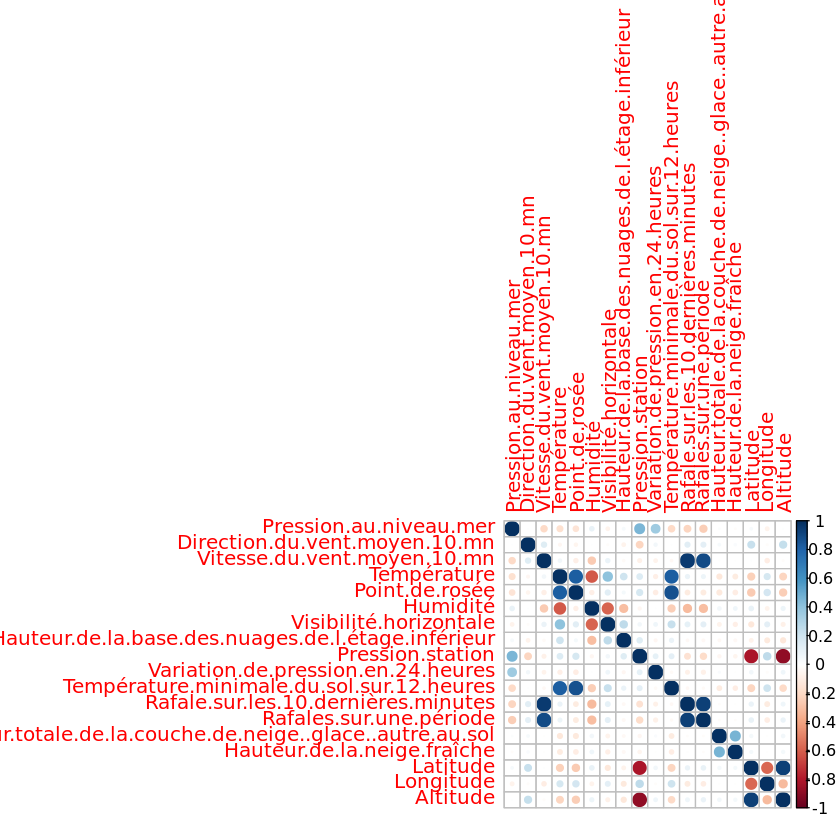

In [20]:
corr_mat = cor(df_clean_reglin)
corrplot(corr_mat)

Correlation interessante et prévue: Température avec Pt de Rosée et Humidité et Temp minimale du sol sur 12 heures
Correlation étonnante Latitude, pression station et Altidude

In [ ]:
expected_lin_reg = df_clean_reglin[, c("Température", "Point.de.rosée", "Humidité", "Température.minimale.du.sol.sur.12.heures")]
head(expected_lin_reg)

,Température,Point.de.rosée,Humidité,Température.minimale.du.sol.sur.12.heures
,<dbl>,<dbl>,<dbl>,<dbl>
7,283.85,276.35,60,279.15
49,283.85,280.35,79,280.25
54,285.65,278.75,63,282.15
57,273.85,271.65,85,273.15
59,286.65,278.25,57,276.05
68,293.75,285.95,61,281.75


In [24]:
temp_lin_reg <- lm(Température ~ ., data = expected_lin_reg)
summary(temp_lin_reg)


Call:
lm(formula = Température ~ ., data = expected_lin_reg)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8337 -0.5403 -0.1841  0.3980 11.2693 

Coefficients:
                                            Estimate Std. Error t value
(Intercept)                               15.5841451  0.3233592   48.20
Point.de.rosée                             0.9784742  0.0024122  405.63
Humidité                                  -0.2426913  0.0004016 -604.36
Température.minimale.du.sol.sur.12.heures  0.0479332  0.0023453   20.44
                                          Pr(>|t|)    
(Intercept)                                 <2e-16 ***
Point.de.rosée                              <2e-16 ***
Humidité                                    <2e-16 ***
Température.minimale.du.sol.sur.12.heures   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8185 on 15280 degrees of freedom
Multiple R-squared:  0.9891,	Adjusted R-squared:  0.9891 
F-statis

Interprétations

On a un $R^2 = 0.9891$ donc globalement la regression linéaire semble a priori très pertinente

Limite identifiée: disymétrie des erreurs $\epsilon_{min} = -1.8337$,  $Med(\epsilon) = -0.1841$; $\epsilon_{max} = 11.2693$


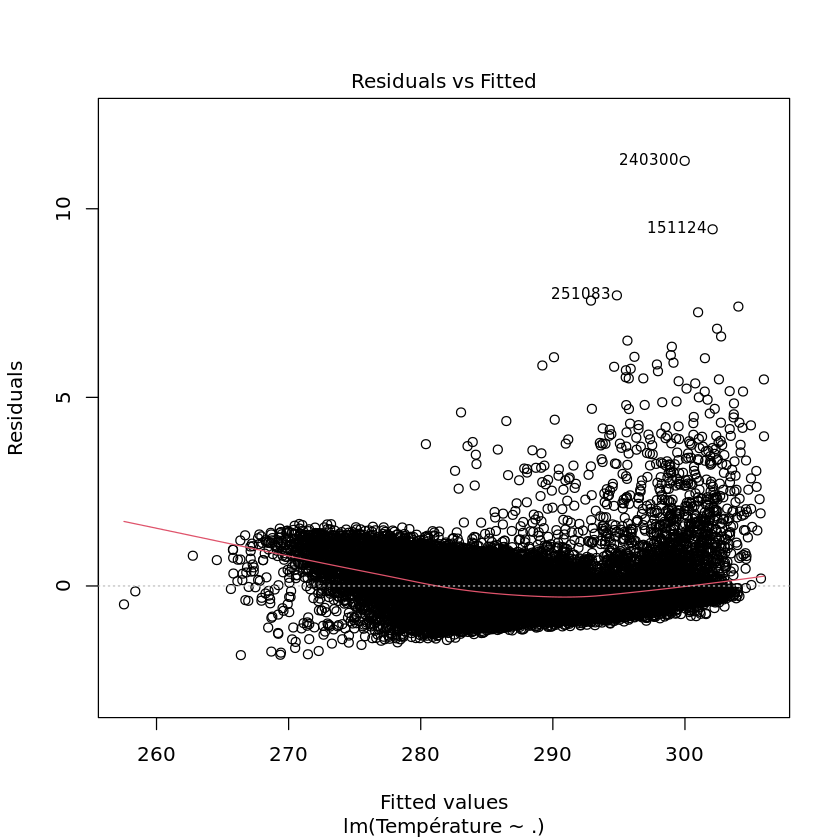

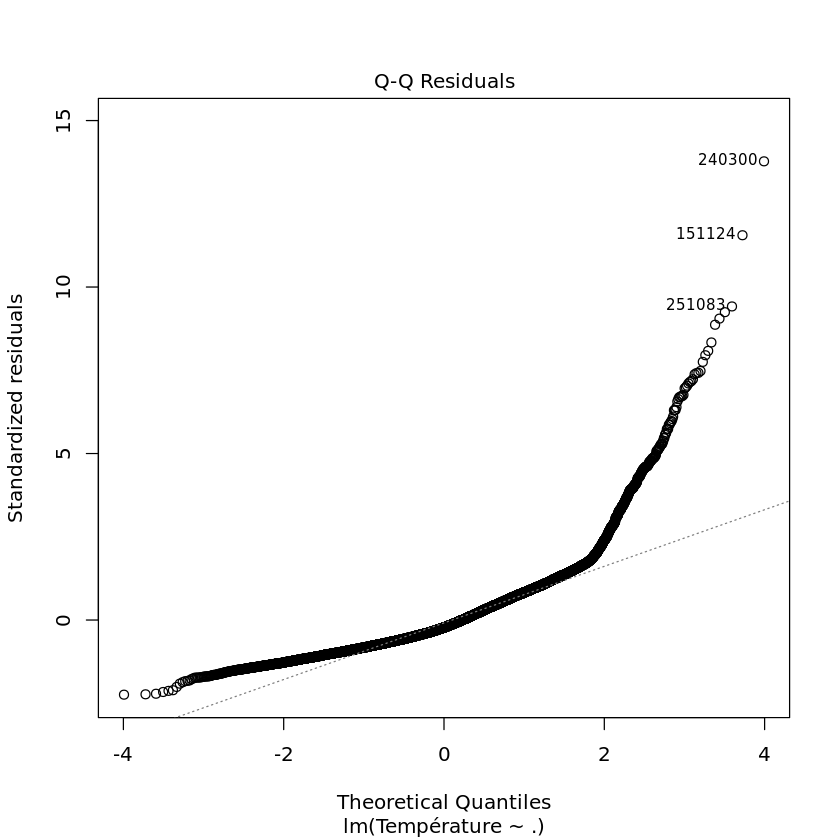

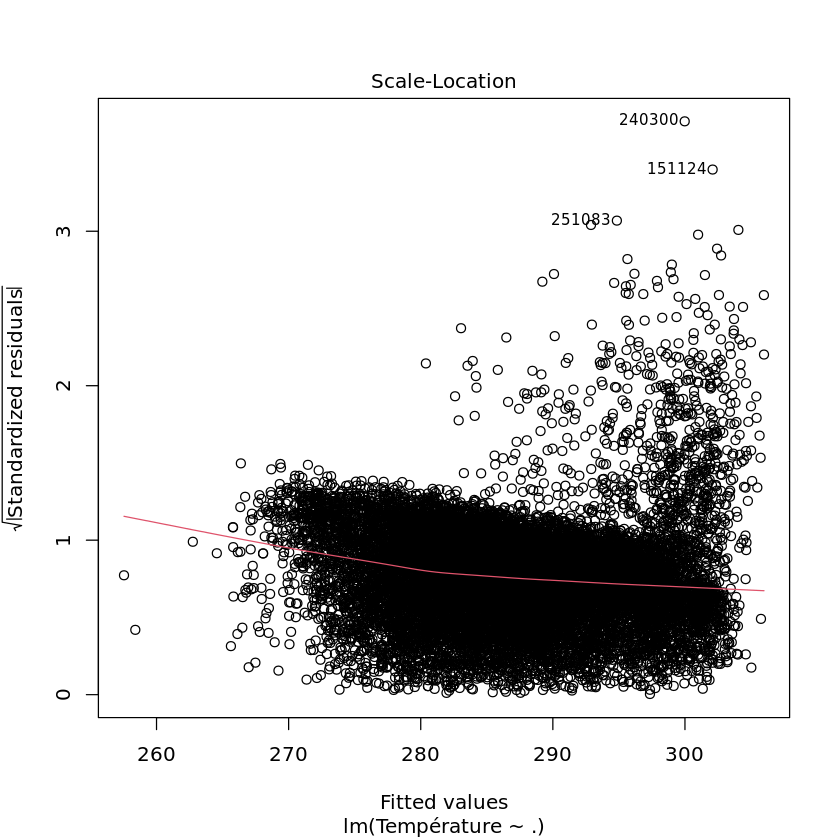

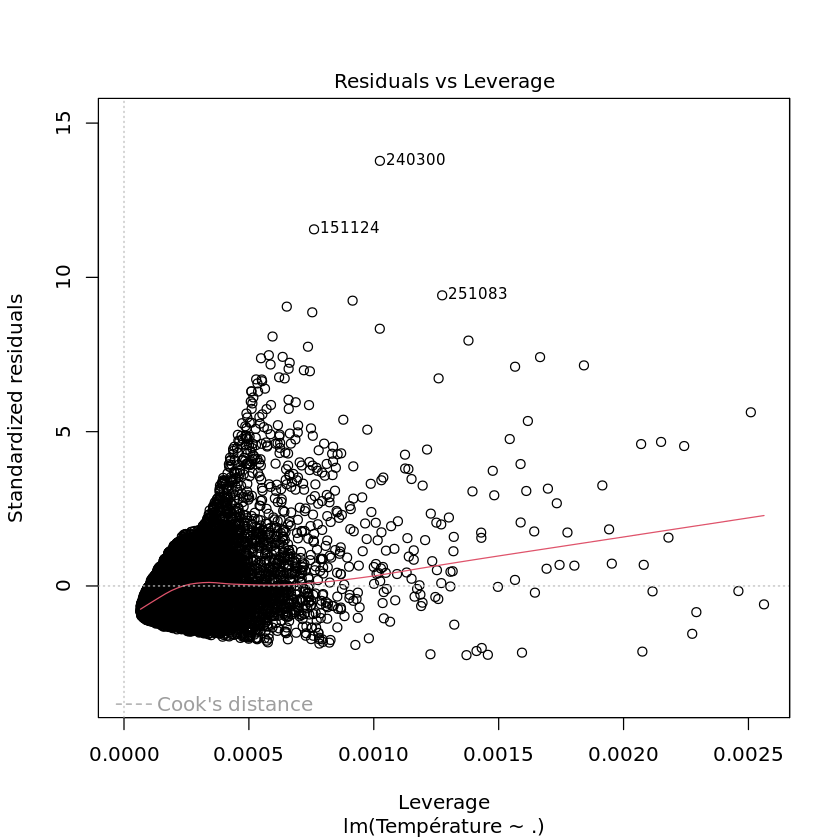

In [28]:
plot(temp_lin_reg)

Clairement la répartition des erreurs n'est pas *Normale* au vu du graphe $QQ$ de plus nous pouvons rejeter l'hypothèse d'une homoscédasticité des erreurs. 

Affinage du modèle, on va retirer les outliers détectés avec la distance de cook


Call:
lm(formula = Température ~ ., data = clean_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8928 -0.3914 -0.1280  0.3028  2.1272 

Coefficients:
                                            Estimate Std. Error t value
(Intercept)                               13.6343275  0.2129625   64.02
Point.de.rosée                             1.0002945  0.0016373  610.95
Humidité                                  -0.2274960  0.0002789 -815.80
Température.minimale.du.sol.sur.12.heures  0.0287627  0.0015737   18.28
                                          Pr(>|t|)    
(Intercept)                                 <2e-16 ***
Point.de.rosée                              <2e-16 ***
Humidité                                    <2e-16 ***
Température.minimale.du.sol.sur.12.heures   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5171 on 14551 degrees of freedom
Multiple R-squared:  0.9952,	Adjusted R-squared:  0.9952 
F-statistic: 1

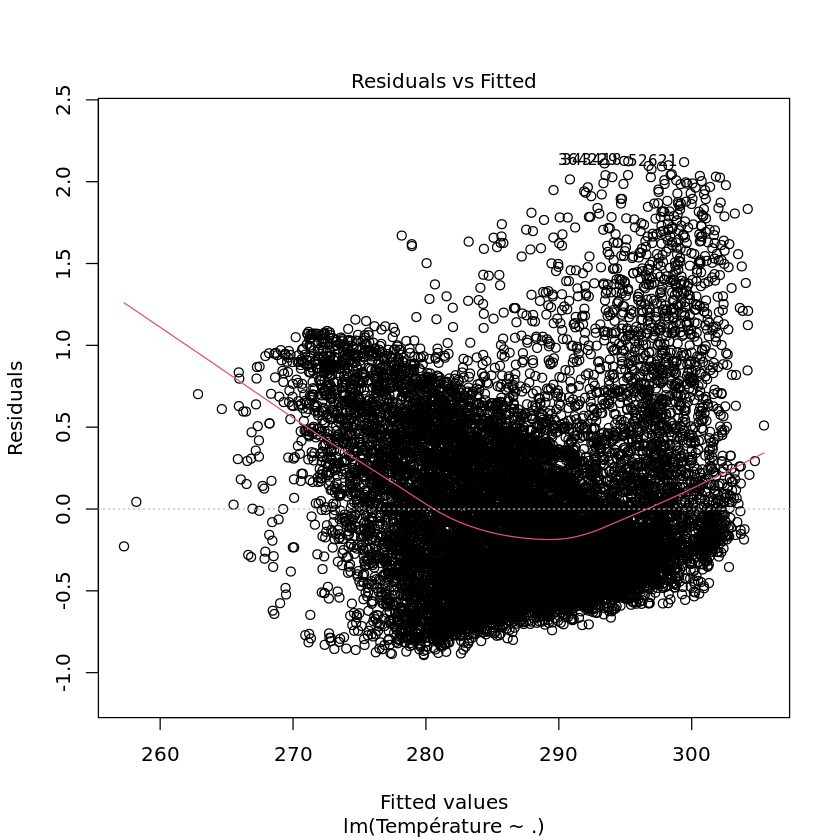

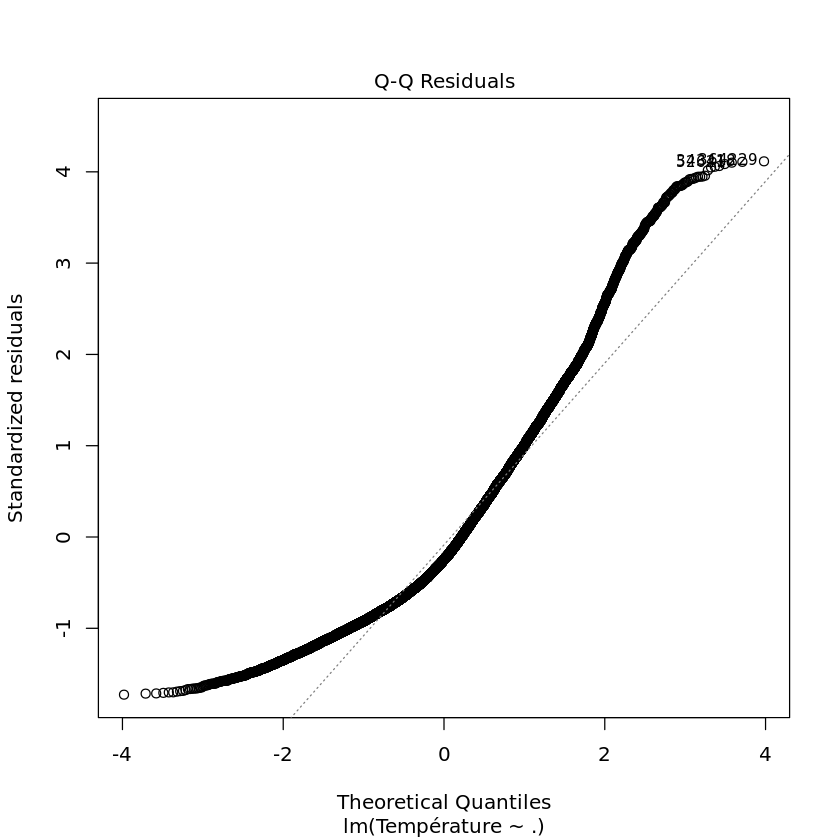

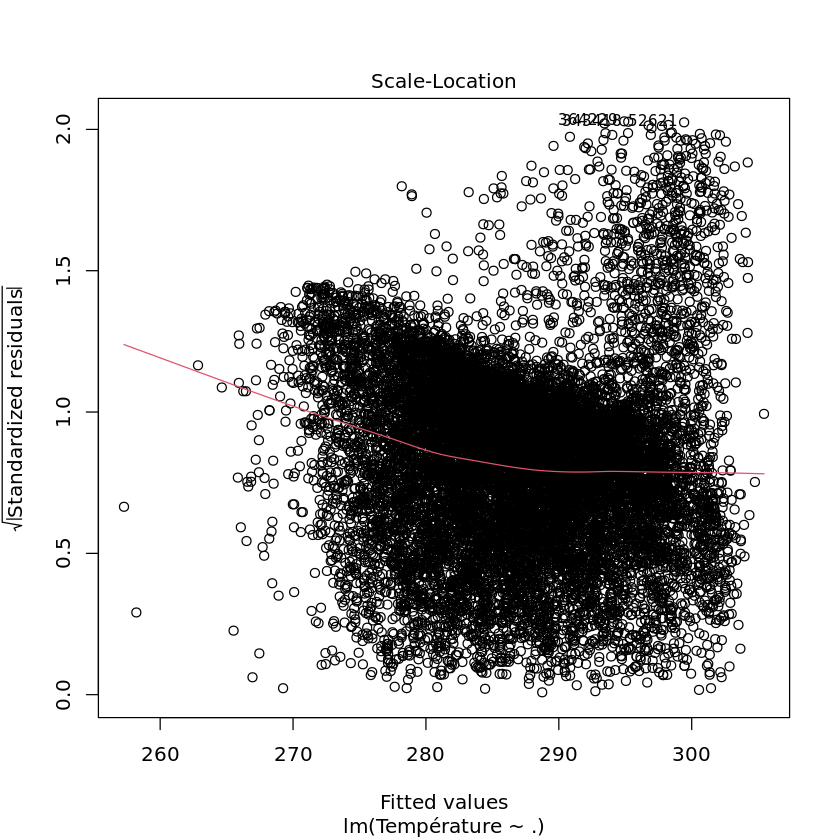

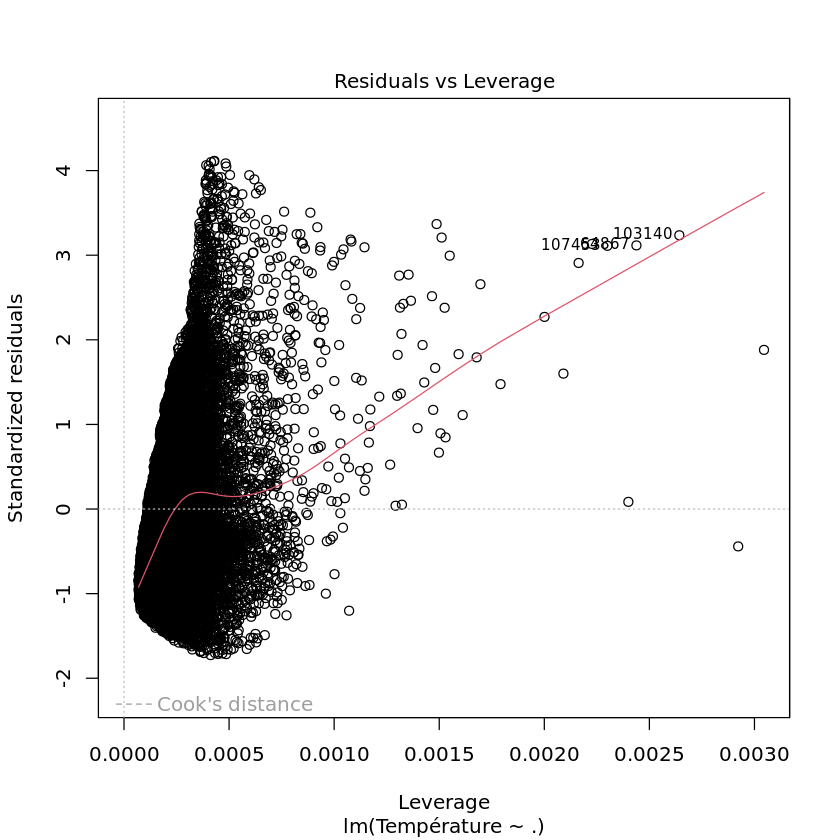

In [42]:
cooksd <- cooks.distance(temp_lin_reg)
outliers_cook <- which(cooksd > 4/length(cooksd))

clean_data <- expected_lin_reg[-outliers_cook, ]
clean_lm <- lm(Température ~ ., data = clean_data)
summary(clean_lm)

plot(clean_lm)

Même si l'ajustement est meilleur, les hypothèses de normalité ne semblent toujours pas validées, suggérant des relations plus complexes ce qui est confirmé par les théories empiriques météorologiques avec l'approximation de Heinrich Gustav-Tetens qui donne une expression non linéaire du point de rosée.
Cf: [Article formule de point de rosée](https://www.wikiwand.com/fr/articles/Point_de_ros%C3%A9e)